# 이상값 탐색 및 처리

## 필요 라이브러리 import

In [1]:
import random    # 의사 난수 생성 패키지
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
if os.name == 'nt':
    font_family = 'Malgun Gothic'

sns.set(font=font_family, rc={'axes.unicode_minus' : False})

## Z검정 ( Z-Test )을 이용한 이상값 처리
### 데이터 생성

In [3]:
# 3000개의 랜덤 데이터 생성
np_data = np.random.randint(1, 100, size= 3000)
data = list(np_data)

In [4]:
data[0:2]

[46, 71]

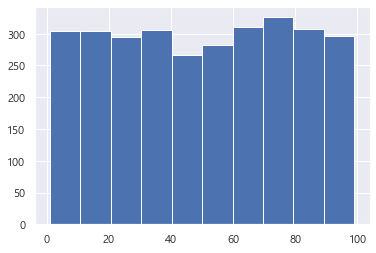

In [5]:
# 히스토그램으로 생성된 데이터 분포 확인
plt.hist(data)
plt.show()

data의 평균값 : 50.102
data의 정규분포 : 28.555786267118147


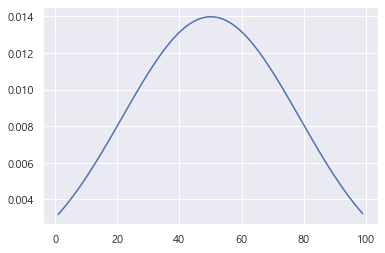

In [6]:
# Data의 정규분포 확인
data_mean = np.mean(data)
data_std = np.std(data)

print(f'data의 평균값 : {data_mean}')
print(f'data의 정규분포 : {data_std}')

# 확률 밀도 함수 생성
pdf = stats.norm.pdf(np.sort(data), data_mean, data_std)

plt.figure()
plt.plot(np.sort(data), pdf)

ol_data_mean : 1.1605531350748302e-16
ol_data_std : 1.0


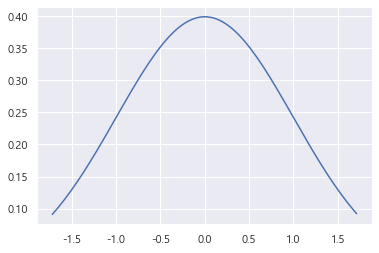

In [7]:
# 표준정규분포(Z분포)로 변환
std_list = []

for i in data:
    z = ( i - data_mean ) / data_std
    std_list.append(z)
    
ol_data_mean = np.mean(std_list)
ol_data_std = np.std(std_list)

print(f'ol_data_mean : {ol_data_mean}')
print(f'ol_data_std : {ol_data_std}')

ol_pdf = stats.norm.pdf(np.sort(std_list),
                        ol_data_mean,
                        ol_data_std)
plt.figure()
plt.plot(np.sort(std_list), ol_pdf)

### 데이터셋에 이상값 추가

ol_data의 평균 : 50.2312292358804
ol_data의 정규분포 : 28.793670080331182


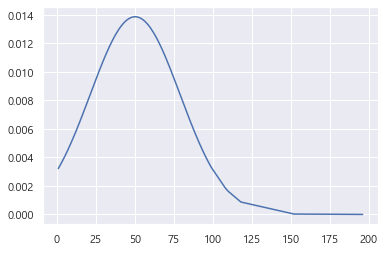

In [9]:
# 이상값 추가
ol_data = data.copy()
ol_no = 10

for i in range(ol_no):
    rand_no = random.randint(0, len(data))
    ol_data.insert(rand_no, ol_data[rand_no]*2)   # 이상값 생성
    
# 이상값이 추가된 데이터의 정규분포도
ol_data_mean = np.mean(ol_data)
ol_data_std = np.std(ol_data)

print(f'ol_data의 평균 : {ol_data_mean}')
print(f'ol_data의 정규분포 : {ol_data_std}')

ol_pdf = stats.norm.pdf(np.sort(ol_data),
                        ol_data_mean,
                        ol_data_std)

plt.figure()
plt.plot(np.sort(ol_data), ol_pdf)

-4.7212141910970115e-18
1.0


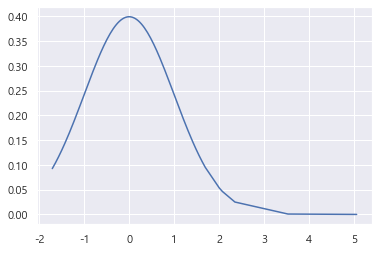

In [10]:
# 이상값 추가된 데이터의 표준화
ol_std_list = []

for i in ol_data:
    z = (i- ol_data_mean)/ol_data_std
    ol_std_list.append(z)
    
ol_st_data_mean = np.mean(ol_std_list)
ol_st_data_std = np.std(ol_std_list)

print(ol_st_data_mean)
print(ol_st_data_std)

ol_std_pdf = stats.norm.pdf(np.sort(ol_std_list),
                            ol_st_data_mean,
                            ol_st_data_std)

plt.figure()
plt.plot(np.sort(ol_std_list), ol_std_pdf)

### Z값의 2가 넘어가는 데이터 삭제

In [11]:
# 전체 라인수 확인
len(ol_std_list)

3010

In [12]:
# -2 ~ 2 범위 벗어나면 이상값으로 제거

for i in ol_std_list:
    z = i
    if z > 2:
        ol_std_list.remove(z)
    if z < -2:
        ol_std_list.remove(z)

In [13]:
# 이상값 제거 후 라인수
len(ol_std_list)

3005

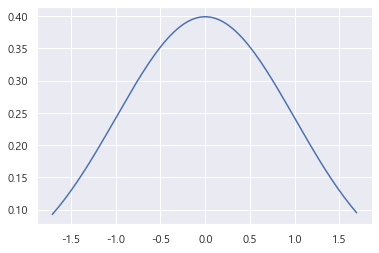

In [14]:
# 이상값 제거 후 표준정규분포 확인
ol_std_pdf = stats.norm.pdf(np.sort(ol_std_list), ol_st_data_mean,
                            ol_st_data_std)

plt.figure()
plt.plot(np.sort(ol_std_list), ol_std_pdf)

## 사분위수 범위로 이상값 삭제
### 이상값 데이터 생성

In [18]:
# 이상값 데이터 생성
boxdata = pd.DataFrame(np.random.randn(100, 3), columns=['A열', 'B열', 'C열'])
boxdata.head()

,A열,B열,C열
0,-0.303658,0.892868,-0.396585
1,0.832390,1.462205,-0.682923
2,0.342068,-0.424271,-0.239026
3,-0.795565,0.651268,-0.410902
4,0.302522,2.377740,-2.726350


### 이상값 데이터 확인 ( 사분위수 범위 확인 )

In [19]:
# 기술 통계 정보로 pencentile 확인
boxdata.describe()

,A열,B열,C열
count,100.000000,100.000000,100.000000
mean,-0.238983,-0.126607,0.027316
std,0.928588,1.017187,1.087951
min,-2.638308,-3.286443,-2.735358
25%,-0.809553,-0.749120,-0.656586
50%,-0.195098,-0.141376,-0.092987
75%,0.474325,0.535512,0.774077
max,1.936221,2.377740,2.707014


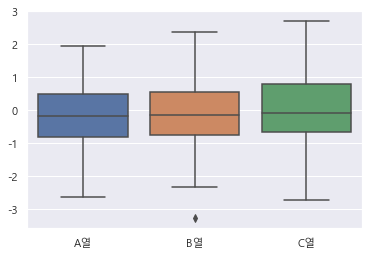

In [20]:
# 박스 플롯을 이용한 이상값 확인
sns.boxplot(data =boxdata)
plt.show()

실습 예제와는 다르게 B열에만 이상값이 관측됨을 확인할 수 있음 ( 난수로 만든 데이터셋이어서 상이할 수 있음 )

### 이상값 확인 및 제거, 재확인

In [21]:
# 이상값 계산하는 함수
def get_outlier(df= None, column=None, weight=1.5):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    outlier_idx = df[column] [ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

In [22]:
# 함수 사용해서 이상값 확인
outlier_idx = get_outlier(df=boxdata, column='B열', weight=1.5)

In [23]:
outlier_idx

Int64Index([44], dtype='int64')

실행결과 44번 인덱스에 이상값 존재하는 걸 확인할 수 있다

In [24]:
# 이상값 삭제
boxdata.drop(outlier_idx, axis=0, inplace=True)

In [25]:
boxdata.shape

(99, 3)

shape 확인 결과, 이상값이 있던 row 삭제된 것을 알 수 있음

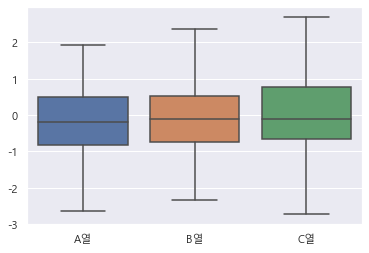

In [26]:
# 박스 플롯을 이용한 이상값 확인
sns.boxplot(data = boxdata)
plt.show()

출력 결과, 이상값 없음 확인

In [29]:
# 함수 사용해서 이상값 확인
outlier_idx = get_outlier(df=boxdata, column='A열', weight=1.5)
outlier_idx

Int64Index([], dtype='int64')

출력 결과, 이상값 없음 확인 ( 반환된 인덱스 위치가 없음 )

In [30]:
outlier_idx = get_outlier(df=boxdata, column='C열', weight=1.5)
outlier_idx

Int64Index([], dtype='int64')

출력 결과, 이상값 없음 확인 ( 반환된 인덱스 위치가 없음 )